# Data Cleaning and Preprocessing

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

In [2]:
# Always anchor relative to this notebook location
ROOT = Path.cwd().parent
DATA = ROOT / "data" / "raw"

train_features = pd.read_csv(DATA / "training_set_features.csv")
train_labels   = pd.read_csv(DATA / "training_set_labels.csv")
test_features  = pd.read_csv(DATA / "test_set_features.csv")

## Handle missing values

,missing_count,missing_pct
employment_occupation,13470,50.44
employment_industry,13330,49.91
health_insurance,12274,45.96
income_poverty,4423,16.56
doctor_recc_seasonal,2160,8.09
doctor_recc_h1n1,2160,8.09
rent_or_own,2042,7.65
employment_status,1463,5.48
marital_status,1408,5.27
education,1407,5.27


<Axes: >

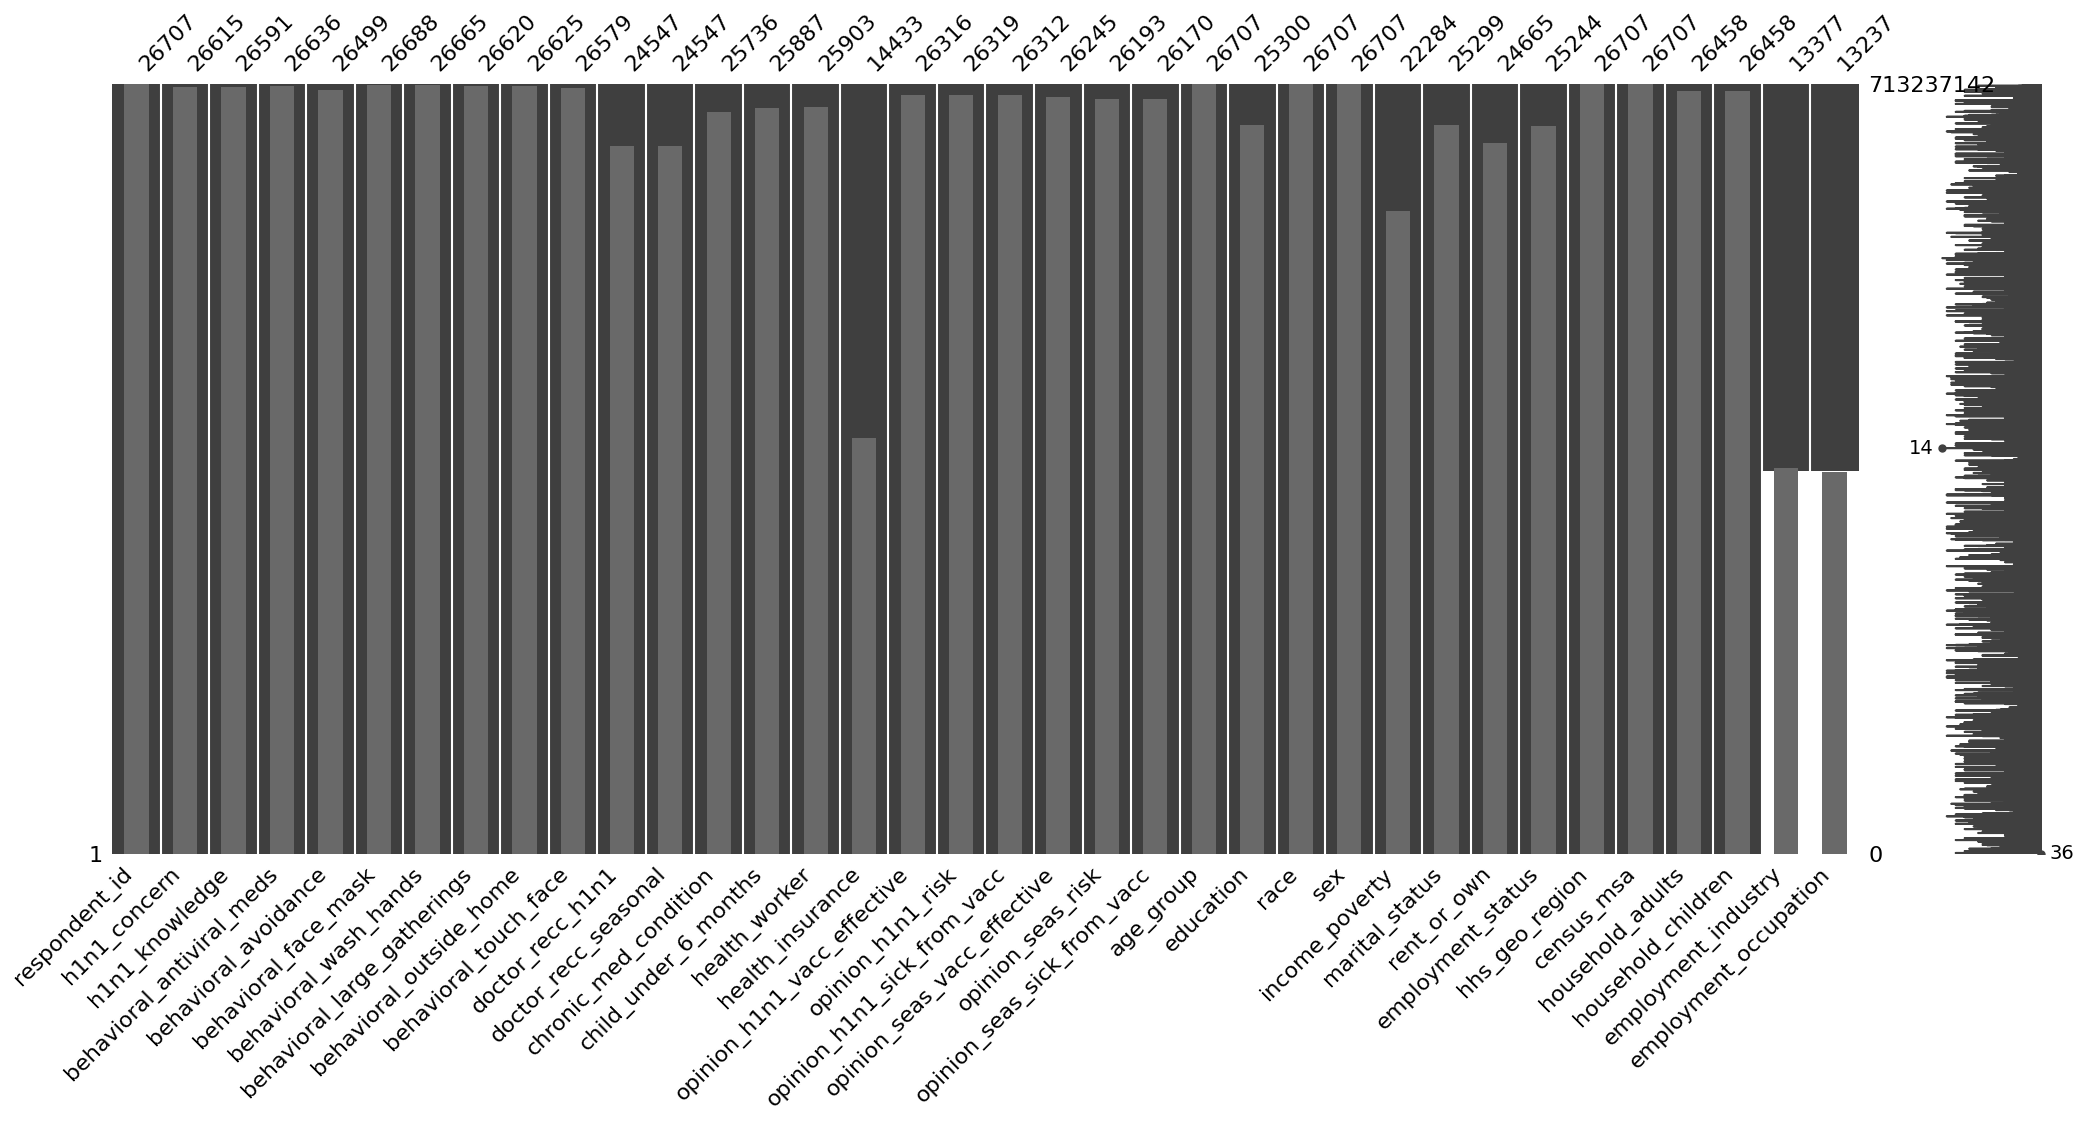

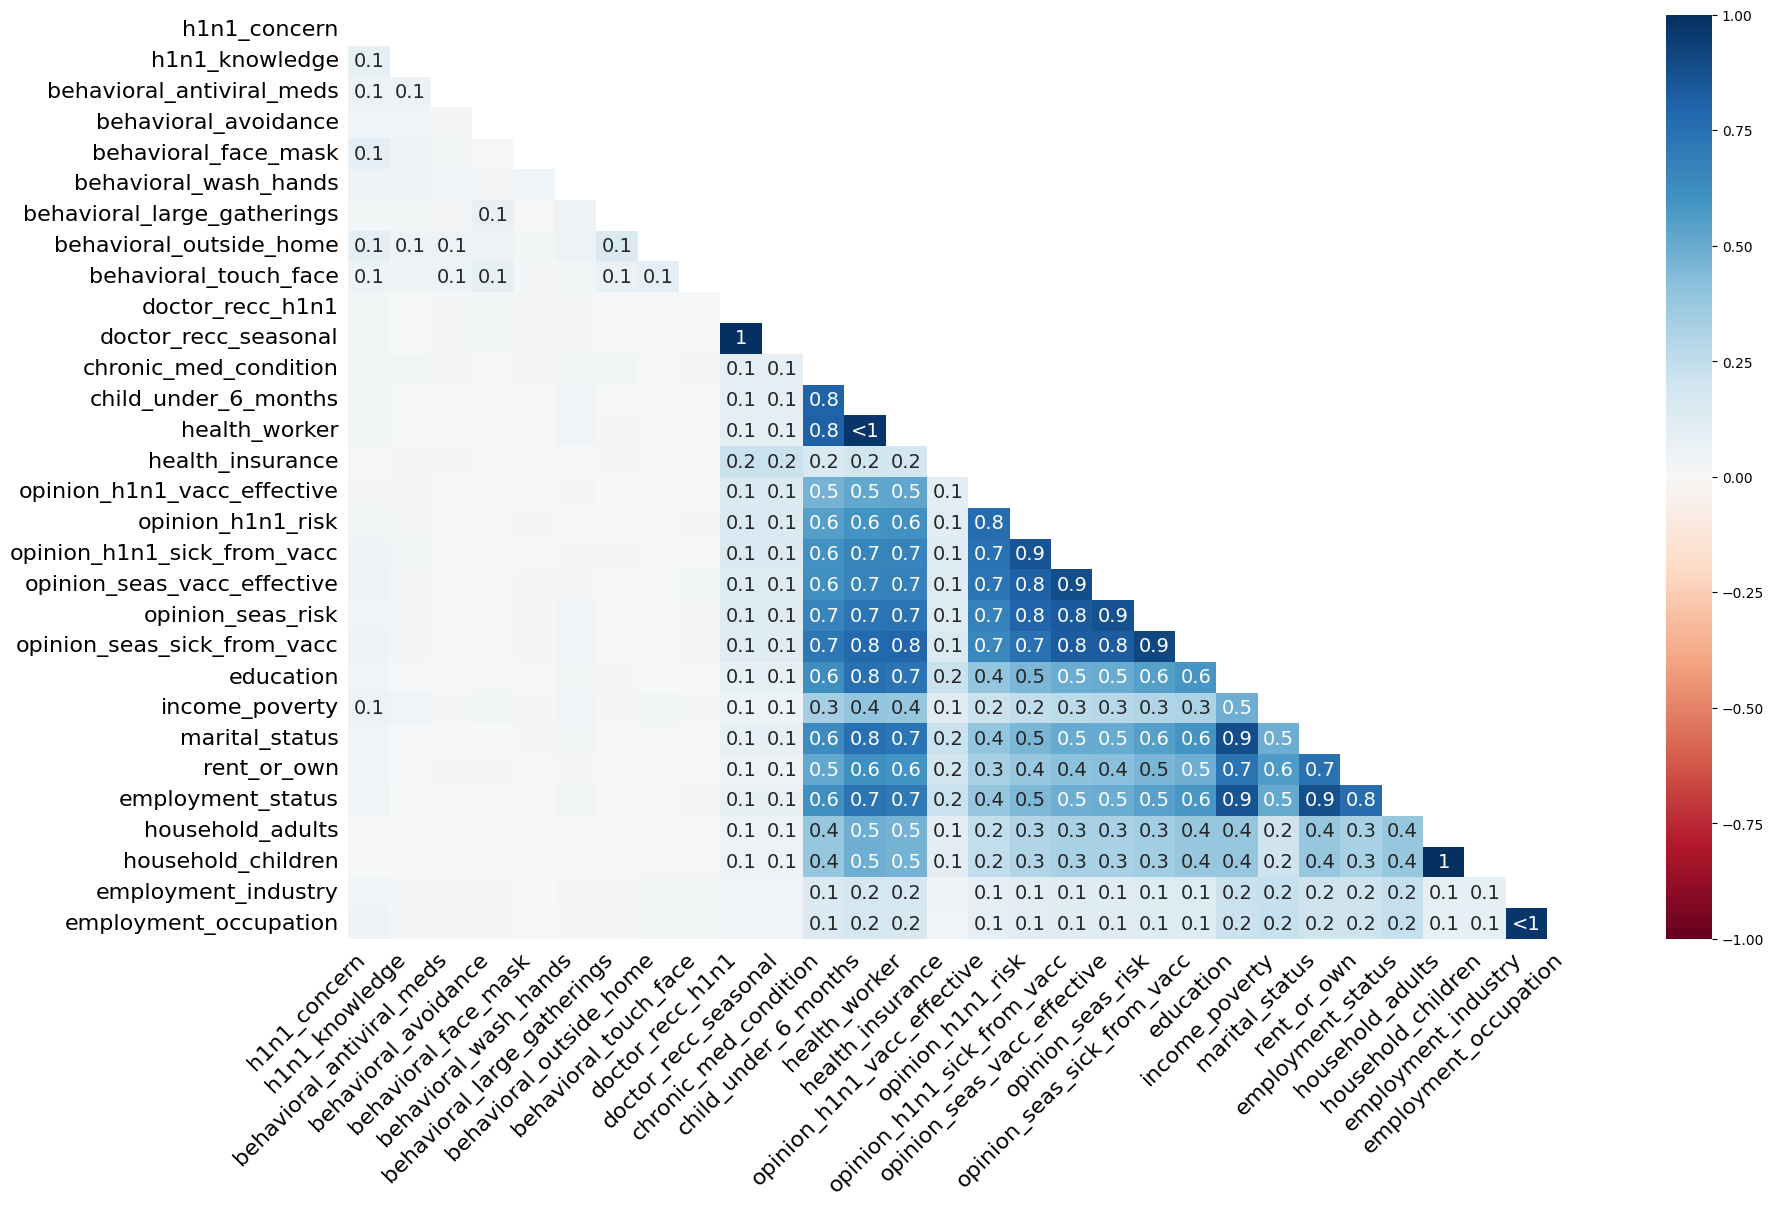

In [3]:
import missingno as msno

# Summary table
missing_summary = (
    train_features.isnull().sum()
    .to_frame(name="missing_count")
    .assign(missing_pct=lambda x: (x["missing_count"] / len(train_features) * 100).round(2))
    .sort_values("missing_count", ascending=False)
)
display(missing_summary)

# Visualize missing values
msno.matrix(train_features)
msno.bar(train_features)

# Correlation of missingness
msno.heatmap(train_features)

**Bar plot** shows where values are missing.

   * Most columns are nearly complete.
   * But `employment_industry`, `employment_occupation`, and `health_insurance` stand out with a lot of missing data.

**Heatmap of missingness correlation** shows how missingness overlaps between features.

   * `employment_industry` and `employment_occupation` are highly correlated (if one is missing, the other usually is).
   * `health_insurance` is somewhat correlated with missingness in socio-economic features (`income_poverty`, `education`, `marital_status`).
   * Doctor recommendation features (`doctor_recc_h1n1`, `doctor_recc_seasonal`) are often missing together.

In [3]:
# Make a copy to avoid overwriting raw data
train_imputed = train_features.copy()

#### Employment-related (`employment_industry`, `employment_occupation`)

* **Problem**: ~50% missing, and strongly correlated missingness (they usually go missing together).
* **Approach**:

  * Don’t drop -- these may still contain useful signal when present.
  * Encode missingness explicitly by adding `"Missing"` category.

* **Rationale**: Missingness itself might be informative (e.g., not employed, not disclosed).

In [4]:
for col in ["employment_industry", "employment_occupation"]:
    train_imputed[col] = train_imputed[col].fillna("Missing")

#### Health Insurance

* **Problem**: ~46% missing, correlated with socio-economic features.
* **Approach**:

  * Create a `"Missing"` category instead of imputing with mode (because missing might mean "no response" rather than random).

* **Rationale**: Preserves possible socio-economic signal.

In [5]:
train_imputed["health_insurance"] = train_imputed["health_insurance"].fillna("Missing")

#### Socio-economic variables (`income_poverty`, `education`, `marital_status`, `employment_status`, `rent_or_own`)

* **Problem**: 5–15% missing.
* **Approach**:

  * Impute categorical features with `"Missing"` label.
  * If treating as ordinal (`education`), could also impute with median group, but `"Missing"` is safer to avoid bias.

In [6]:
cat_cols = ["income_poverty", "education", "marital_status", "employment_status", "rent_or_own"]
for col in cat_cols:
    train_imputed[col] = train_imputed[col].fillna("Missing")

#### Doctor recommendations (`doctor_recc_h1n1`, `doctor_recc_seasonal`)

* **Problem**: ~8% missing, often missing together.
* **Approach**:

  * Impute with `0` (assume "no recommendation").
* **Rationale**: Likely not random - doctor may not have been asked / not available.

In [7]:
for col in ["doctor_recc_h1n1", "doctor_recc_seasonal"]:
    train_imputed[col] = train_imputed[col].fillna(0)

#### Opinion/behavioral features (1-5 scale or binary indicators)

* **Problem**: <3% missing (low).
* **Approach**:

  * Median imputation (numeric, preserves ordinal scale).
  * For binary (0/1), median = mode -> equivalent to majority imputation.

In [8]:
opinion_behavior_cols = [
    "h1n1_concern", "h1n1_knowledge",
    "behavioral_antiviral_meds", "behavioral_avoidance", "behavioral_face_mask",
    "behavioral_wash_hands", "behavioral_large_gatherings",
    "behavioral_outside_home", "behavioral_touch_face",
    "chronic_med_condition", "child_under_6_months", "health_worker",
    "opinion_h1n1_vacc_effective", "opinion_h1n1_risk", "opinion_h1n1_sick_from_vacc",
    "opinion_seas_vacc_effective", "opinion_seas_risk", "opinion_seas_sick_from_vacc"
]

for col in opinion_behavior_cols:
    median_val = train_imputed[col].median()
    train_imputed[col] = train_imputed[col].fillna(median_val)

#### Household counts (`household_adults`, `household_children`)

* **Problem**: ~1% missing.
* **Approach**:

  * Median imputation (since counts are skewed, median is robust).

In [9]:
for col in ["household_adults", "household_children"]:
    median_val = train_imputed[col].median()
    train_imputed[col] = train_imputed[col].fillna(median_val)

In [10]:
# Check missingness resolved

print("Missing values left:", train_imputed.isnull().sum().sum())

Missing values left: 0


In [13]:
# Save a csv file for imputed training dataset into folder data > interim > training_imputed.csv

SAVE_PATH = ROOT / "data" / "interim"

train_imputed.to_csv(SAVE_PATH / "training_imputed.csv")

#### For proper modeling, all imputers must be fit on the training set only, then applied to the test set
We'll split into two functions to be found in ***src/preprocessing.py***:
* fit_imputers(df_train) -- learns medians from train
* impute_dataset(df, imputers) -- applies the same rules + uses train medians for test

In [13]:
import sys, os
repo_root = os.path.abspath("..")
if repo_root not in sys.path:
    sys.path.append(repo_root)

from src.preprocessing import fit_imputers, impute_dataset

# Fit imputers on training set
imputers = fit_imputers(train_features)

# Apply imputation to test dataset
test_imputed  = impute_dataset(test_features, imputers)

# Check missingness
print("Test dataset missing values left:", test_imputed.isnull().sum().sum())

Test dataset missing values left: 0


## Convert categorical variables to appropriate formats

In [14]:
# Identify categorical columns
cat_cols = train_imputed.select_dtypes(include="object").columns.tolist()

print("Number of categorical features:", len(cat_cols))
print("Categorical columns:", cat_cols)

Number of categorical features: 13
Categorical columns: ['health_insurance', 'age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa', 'employment_industry', 'employment_occupation']


In [15]:
# Check number of unique categories per column
cat_summary = (
    train_imputed[cat_cols]
    .nunique()
    .reset_index()
    .rename(columns={"index": "feature", 0: "unique_values"})
    .sort_values("unique_values", ascending=False)
)

print(cat_summary)

                  feature  unique_values
12  employment_occupation             24
11    employment_industry             22
9          hhs_geo_region             10
2               education              5
1               age_group              5
8       employment_status              4
5          income_poverty              4
3                    race              4
0        health_insurance              3
7             rent_or_own              3
6          marital_status              3
10             census_msa              3
4                     sex              2


In [16]:
# Look at actual category values
for col in cat_cols:
    print(f"\n--- {col} ---")
    print(train_imputed[col].value_counts(dropna=False).head(10))


--- health_insurance ---
health_insurance
1.0        12697
Missing    12274
0.0         1736
Name: count, dtype: int64

--- age_group ---
age_group
65+ Years        6843
55 - 64 Years    5563
45 - 54 Years    5238
18 - 34 Years    5215
35 - 44 Years    3848
Name: count, dtype: int64

--- education ---
education
College Graduate    10097
Some College         7043
12 Years             5797
< 12 Years           2363
Missing              1407
Name: count, dtype: int64

--- race ---
race
White                21222
Black                 2118
Hispanic              1755
Other or Multiple     1612
Name: count, dtype: int64

--- sex ---
sex
Female    15858
Male      10849
Name: count, dtype: int64

--- income_poverty ---
income_poverty
<= $75,000, Above Poverty    12777
> $75,000                     6810
Missing                       4423
Below Poverty                 2697
Name: count, dtype: int64

--- marital_status ---
marital_status
Married        13555
Not Married    11744
Missing         

* **Total categorical features**: 13
* **Columns**:

  * health_insurance (3 unique values: 0, 1, Missing)
  * age_group (5 ordered categories)
  * education (5 ordered categories including Missing)
  * race (4 values)
  * sex (2 values)
  * income_poverty (4 ordered categories including Missing)
  * marital_status (3 values including Missing)
  * rent_or_own (3 values including Missing)
  * employment_status (4 values including Missing)
  * hhs_geo_region (10 values)
  * census_msa (3 values)
  * employment_industry (22 values + Missing)
  * employment_occupation (24 values + Missing)

### Encoding Strategy Summary

| Feature Type | Features | Encoding Method | Rationale |
|---------------|-----------|-----------------|------------|
| **Ordinal** | `age_group`, `education`, `income_poverty` | Ordinal mapping (predefined integer mapping) | Preserves order; avoids false nominal expansion. |
| **Small Nominal (2–3 categories)** | `sex`, `marital_status`, `rent_or_own`, `health_insurance` | One-Hot Encoding | Prevents false linearity; compatible with all model types. |
| **Medium Nominal (4–10 categories)** | `race`, `employment_status`, `census_msa`, `hhs_geo_region` | One-Hot Encoding | Low dimensionality; keeps categorical independence explicit. |
| **High Cardinality (>20 categories)** | `employment_industry`, `employment_occupation` | Target Encoding (per target variable) | Encodes true predictive signal from target means while avoiding dimensional explosion. |
| **Numeric Features** | – | Unchanged / scaled later | Ready for model input. |

### Target Encoding Details
- Two target variables are used separately for target encoding:
  - `h1n1_vaccine`
  - `seasonal_vaccine`
- For each high-cardinality column, two new encoded features are created:
  - `employment_industry_te_h1n1`, `employment_industry_te_seasonal`
  - `employment_occupation_te_h1n1`, `employment_occupation_te_seasonal`
- Encoding used **K-Fold mean target encoding** to prevent leakage.

### Implementation Notes
- Encodings and imputations implemented in `src/preprocessing.py`.
- Ordinal mappings stored in `src/mappings.py`.
- Train and test sets aligned after encoding to ensure matching columns.
- One-hot encoding used `drop_first=True` to prevent multicollinearity.

In [17]:
from src.preprocessing import encode_categoricals

# Merge labels with train_imputed for target encoding
train_for_encoding = train_imputed.merge(
    train_labels[["respondent_id", "h1n1_vaccine", "seasonal_vaccine"]],
    on="respondent_id",
    how="left"
)

# Apply encoding
train_encoded, test_encoded = encode_categoricals(
    train_df=train_for_encoding,
    test_df=test_imputed,
    train_labels=train_labels
)

# Drop target columns from encoded training set (they were only for encoding)
train_encoded.drop(columns=["h1n1_vaccine", "seasonal_vaccine"], errors="ignore", inplace=True)

# Align columns between train and test
test_encoded = test_encoded.reindex(columns=train_encoded.columns, fill_value=0)

# Verify results
print(f"Train encoded shape: {train_encoded.shape}")
print(f"Test  encoded shape: {test_encoded.shape}")

Train encoded shape: (26707, 54)
Test  encoded shape: (26708, 54)


In [18]:
train_encoded.head(10)

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,employment_industry_te_h1n1_vaccine,employment_industry_te_seasonal_vaccine,employment_occupation_te_h1n1_vaccine,employment_occupation_te_seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,False,False,False,False,True,False,0.206458,0.506317,0.207446,0.506761
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,False,False,False,False,False,False,0.136307,0.342007,0.136259,0.327945
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,True,0.150115,0.228637,0.202646,0.412953
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,False,True,False,False,False,False,0.206458,0.506317,0.207446,0.506761
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,False,False,False,False,False,True,0.245243,0.445384,0.238048,0.453187
5,5,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,False,False,False,False,False,False,0.189091,0.305455,0.197133,0.351254
6,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,True,0.123033,0.237482,0.202703,0.428165
7,7,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,False,False,False,False,False,False,0.136307,0.342007,0.147059,0.331551
8,8,0.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,False,False,False,False,False,False,0.124629,0.224036,0.153285,0.343066
9,9,2.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,False,False,False,False,False,True,0.210428,0.511253,0.211098,0.511460


## Check for and handle outliers if necessary

In [19]:
# Identify numeric columns in the encoded dataset
import matplotlib.pyplot as plt
num_cols = train_encoded.select_dtypes(include=["float64", "int64"]).columns

# Drop ID feature
num_cols = num_cols.drop("respondent_id")

print("Numeric columns to check:", len(num_cols))

Numeric columns to check: 29


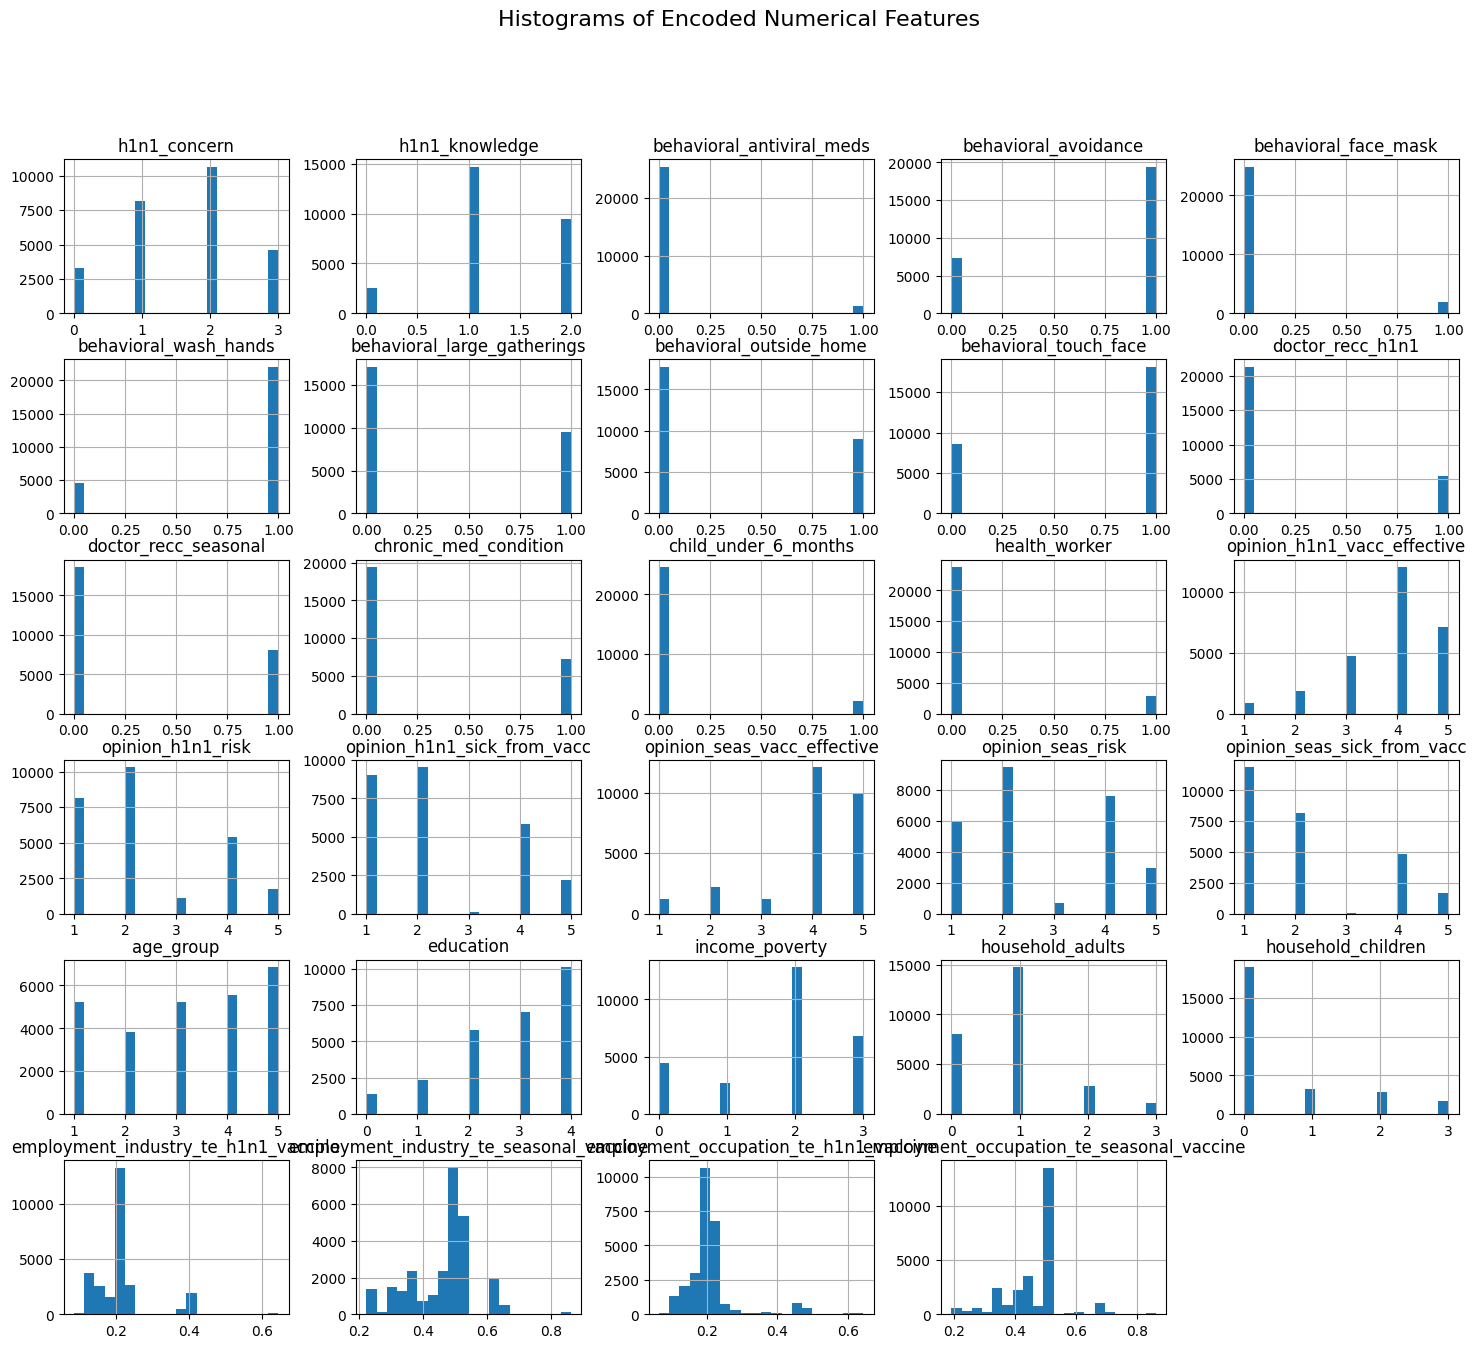

In [20]:
# Plot histograms of numeric features
train_encoded[num_cols].hist(bins=20, figsize=(18, 15))
plt.suptitle("Histograms of Encoded Numerical Features", fontsize=16)
plt.show()

### Observations

* **Binary features (0/1)**:

  * Examples: `behavioral_*`, `doctor_recc_*`, `chronic_med_condition`, `child_under_6_months`, `health_worker`.
  * These are bounded, hence no outliers possible.

* **Ordinal/scale features** (0–3 or 1–5 survey responses):

  * Examples: `h1n1_concern`, `h1n1_knowledge`, `opinion_*`, `age_group`, `education`, `income_poverty`.
  * Values fall into expected discrete buckets, hence no outliers.

* **Household counts** (`household_adults`, `household_children`):

  * Histograms show values only in {0, 1, 2, 3}.
  * Dataset uses **capped coding (3 = “3 or more”)**.
  * No extreme values, hence no outliers.

* **Frequency-encoded features** (`employment_industry`, `employment_occupation`):

  * Values between 0 and 1 by design.
  * No outliers.

### Conclusion

* **No meaningful outliers found**.
* No treatment (removal, capping, winsorization) required.
* Outlier check completed and documented.

## Normalize/standardize numerical features if appropriate



* **Conclusion:** Normalization or standardization is not necessary given the bounded, categorical/ordinal nature of the numerical features.
* **Rationale:**

  * All numeric features are discrete and low-range (0-5).
  * Binary/ordinal variables retain interpretability in raw form.
  * Frequency-encoded features are already scaled (0-1).

## Create a data cleaning pipeline that can be reused for test data

The test data have already been processed along with the train data.
The resulting dataframes are 'train_encoded' and 'test_encoded'.
Creating the scikit-learn pipeline will be addressed later after tackling the modeling stage, to make sure no different approach is necessary.


In [ ]:
# Save csv files into folder data > interim > test_encoded.csv & traning_encoded.csv

train_encoded.to_csv(SAVE_PATH / "training_encoded.csv")
test_encoded.to_csv(SAVE_PATH / "test_encoded.csv")